In [1]:
import sys
sys.path.append('..')

In [2]:
import tensorflow as tf
from tensorflow import keras

from run_utils import setup
from configs import vae_wrapper_config as config
from models import unet
from capsa import VAEWrapper
from callbacks import VisCallback
from utils import notebook_select_gpu, load_depth_data, load_apollo_data, \
    get_normalized_ds, visualize_vae_depth_map

notebook_select_gpu(3, False)

4 Physical GPUs, 1 Logical GPU


In [3]:
(x_train, y_train), (x_test, y_test) = load_depth_data()

ds_train = get_normalized_ds(x_train[:config.N_TRAIN], y_train[:config.N_TRAIN])
ds_test = get_normalized_ds(x_test, y_test)

_, (x_ood, y_ood) = load_apollo_data()
ds_ood = get_normalized_ds(x_ood, y_ood)

In [4]:
model_name = 'notebook_vae'
path, checkpoints_path, vis_path, plots_path, logs_path = setup(model_name)

## Train

In [ ]:
vis_callback = VisCallback(checkpoints_path, logs_path, model_name, ds_train, ds_test)

model = VAEWrapper(
    get_vae_encoder((128, 160, 3), is_reshape=False), # (B, 8, 10, 4) or (B, 320)
    get_decoder((8, 10, 4), num_class=3), # (B, 8, 10, 4) -> (B, 128, 160, 3)
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.LR),
    # loss=MSE,
)

history = model.fit(ds_train, epochs=config.EP,
    validation_data=ds_test,
    callbacks=[vis_callback],
)

In [ ]:
visualize_vae_depth_map(model, ds_train, vis_path, 'train', is_show=True)
visualize_vae_depth_map(model, ds_test, vis_path, 'test', is_show=True)
visualize_vae_depth_map(model, ds_ood, vis_path, 'ood', is_show=True)

In [ ]:
# loss curves and visualisations

%load_ext tensorboard
# %reload_ext tensorboard

%tensorboard --logdir config.LOGS_PATH --host localhost --port 8888

## Load trained model

In [5]:
from utils import load_model, select_best_checkpoint

# path, model_name = select_best_checkpoint('/home/iaroslavelistratov/results/vae/2. size of latent/20220911-184729kl-0.0000005-lr-x6-latent-480')
path, _ = select_best_checkpoint('/home/iaroslavelistratov/results/vae/3. size of latent/20220911-184729kl-0.0000005-lr-x6-latent-480')
trained_model = load_model(path, model_name, ds_train, opts={'latent_dim':480}, quite=False)

Successfully loaded weights from /home/iaroslavelistratov/results/vae/3. size of latent/20220911-184729kl-0.0000005-lr-x6-latent-480/checkpoints/0.009vloss_54740iter.tf.


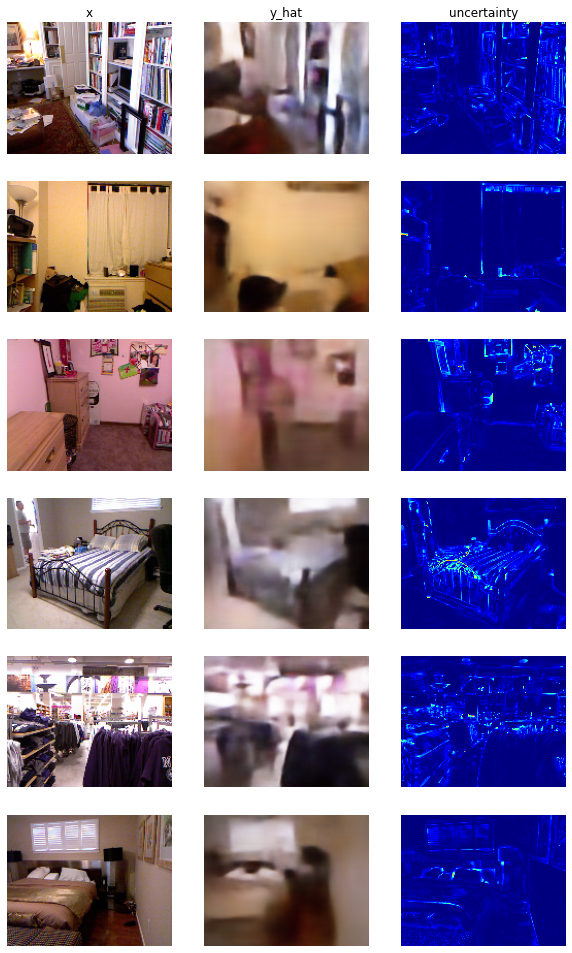

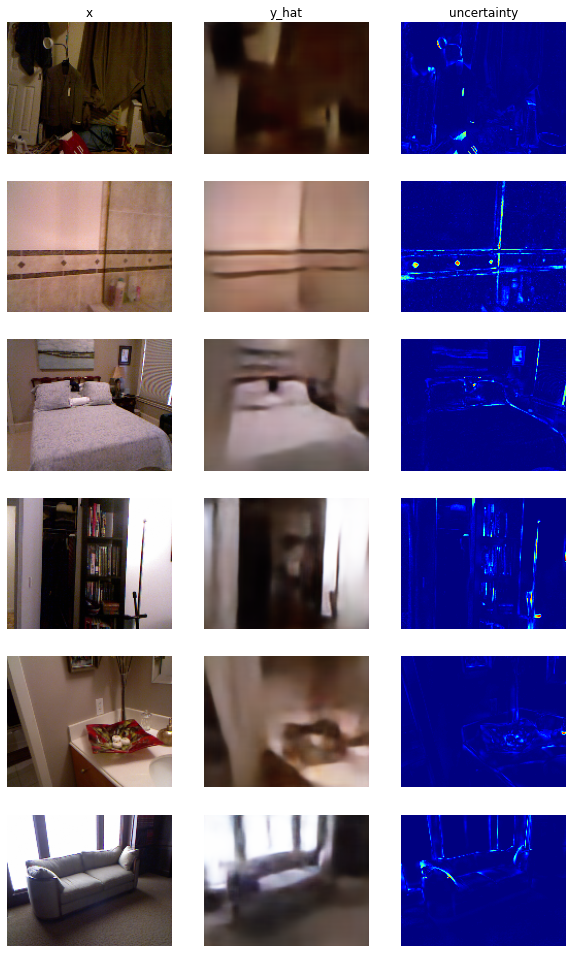

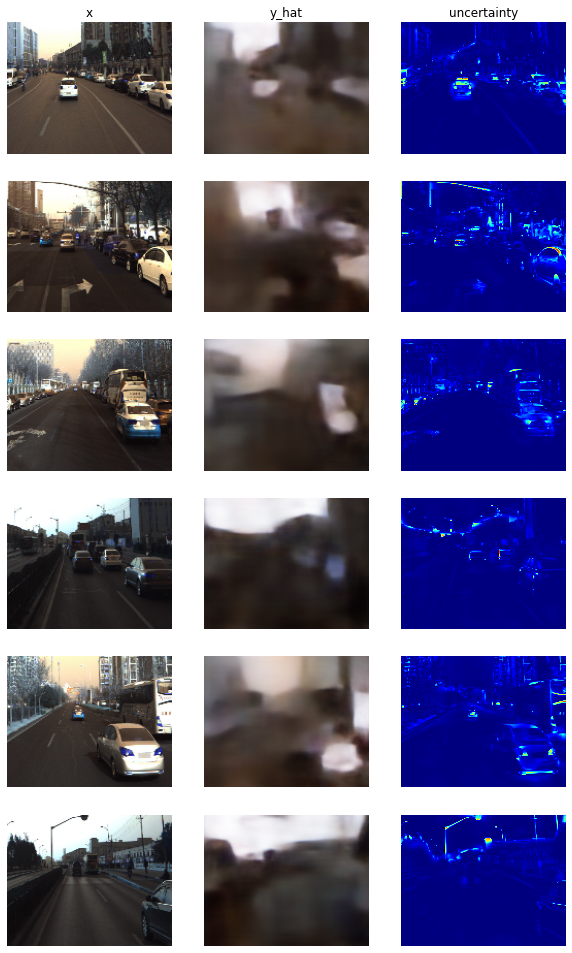

In [6]:
from utils import visualize_vae_depth_map

visualize_vae_depth_map(trained_model, ds_train, vis_path, f'trained_train', is_show=True)
visualize_vae_depth_map(trained_model, ds_test, vis_path, f'trained_test', is_show=True)
visualize_vae_depth_map(trained_model, ds_ood, vis_path, f'trained_ood', is_show=True)

## Calibration curve

In [16]:
# from visualizations import gen_calibration_plot
# gen_calibration_plot(trained_model, ds_test)

In [12]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

mu_ = []
std_ = []
y_test_ = []

for (x_test_batch, y_test_batch) in ds_test:
    # todo-med: better use model.predict, it's more optimized
    # y_hat, z_mean, z_log_var
    y_hats = []

    for i in range(5):
        # todo-med: better use model.predict, it's more optimized
        # need training True for sampling
        y_hat, _, _ = trained_model(x_test_batch, training=True)
        y_hats.append(y_hat)
    y_hats = np.stack(y_hats, 0)
    mu_batch = tf.reduce_mean(y_hats, 0)
    std_batch = tf.math.reduce_std(y_hats, 0)

    mu_.append(mu_batch)
    std_.append(std_batch)
    y_test_.append(x_test_batch) # todo-high: for VAE and AE only

# todo-high: this should be (3029, 128, 160, 1) in other words y_hat
mu = np.concatenate(mu_) #(3029, 128, 160, 3)
std = np.concatenate(std_) #(3029, 128, 160, 3)
y_test = np.concatenate(y_test_) #(3029, 128, 160, 3)

vals = []
percentiles = np.arange(41)/40
for percentile in percentiles:
    # returns the value at the n% percentile e.g., stats.norm.ppf(0.5, 0, 1) == 0.0
    # in other words, if have a normal distrib. with mean 0 and std 1, 50% of data falls below and 50% falls above 0.0.
    ppf_for_this_percentile = stats.norm.ppf(percentile, mu, std) # (3029, 128, 160, 3)
    vals.append((y_test <= ppf_for_this_percentile).mean()) # (3029, 128, 160, 3) -> scalar

plt.plot(percentiles, vals)
plt.plot(percentiles, percentiles)
plt.title(str(np.mean(abs(percentiles - vals))))
plt.show()

## OOD plot

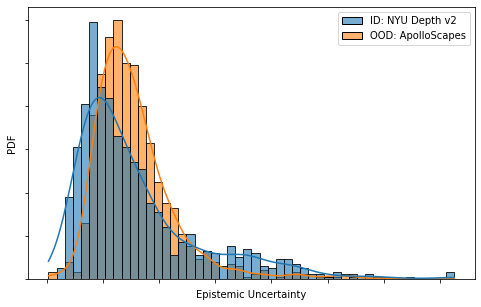

In [12]:
import os
import glob
import h5py
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

def gen_ood_comparison(ds_test, ds_ood, model):
    def _itter_and_cat(ds, model):
        ds_itter = ds.as_numpy_iterator()
        l = []
        for x, y in ds_itter: # (32, 128, 160, 3), (32, 128, 160, 1)


            y_hat, _, epistemic = model(x, training=False) # (32, 128, 160, 1)


            # y_hats = []
            # for i in range(5):
            #     # need training Ture for sampling
            #     y_hat, _ = model(x, training=True)
            #     y_hats.append(y_hat)
            # y_hats = np.stack(y_hats, 0)
            # mu_batch = tf.reduce_mean(y_hats, 0)
            # std_batch = tf.math.reduce_std(y_hats, 0)
            # y_hat = mu_batch
            # epistemic = std_batch


            # # y_hat, _ = model(x, training=False)
            # epistemic = tf.reduce_sum(tf.math.square(x - y_hat), axis=[1,2,3]) # (B, 128, 160, 1)
            # print(epistemic.shape)

            # print(epistemic.shape)
            per_sample_means = tf.reduce_mean(epistemic, axis=[1,2,3])
            l.append(per_sample_means)
        cat = tf.concat(l, axis=0)

        return cat

    iid = _itter_and_cat(ds_test, model)
    ood = _itter_and_cat(ds_ood, model)

    # make num of elements the same
    N = min(iid.shape[0], ood.shape[0])
    df = pd.DataFrame({'ID: NYU Depth v2': iid[:N], 'OOD: ApolloScapes' : ood[:N]})

    fig, ax = plt.subplots(figsize=(8, 5))
    plot = sns.histplot(data=df, kde=True, bins=50, alpha=0.6);
    plot.set(xlabel='Epistemic Uncertainty', ylabel='PDF');
    plot.set(xticklabels=[]);
    plot.set(yticklabels=[]);

gen_ood_comparison(ds_test, ds_ood, trained_model)

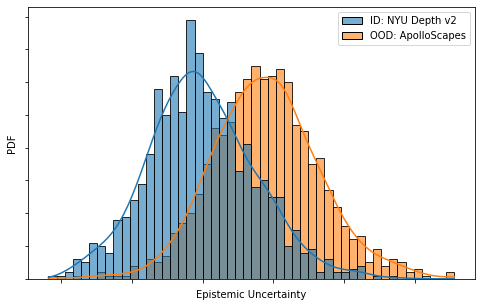

## Interpolation

##### From normal

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from random import sample
import tensorflow as tf
from tensorflow import keras

from callbacks import gallery
from matplotlib.pyplot import figure

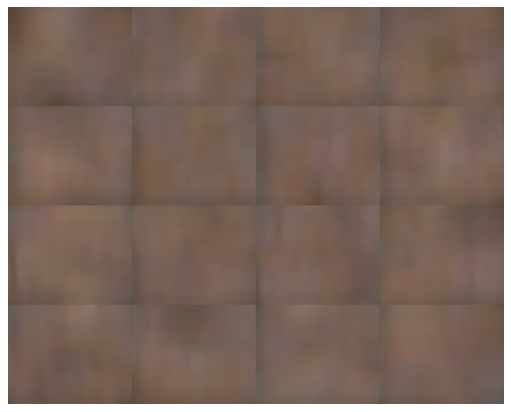

In [60]:
B = 16
# dim = 8 * 10 * 6
dim = 480

sampled_latent_vector = tf.random.normal(shape=(B, dim), mean=0.0, stddev=1) # (B, 8 * 10 * 6)
# sampled_latent_vector = tf.reshape(sampled_latent_vector, [B, 8, 10, -1]) # (B, 320) -> (B, 8, 10, 4)
reconstruction = trained_model.decoder(sampled_latent_vector, training=False)

figure(figsize=(8, 8), dpi=80)
plt.axis('off')
plt.imshow(gallery(reconstruction[:16].numpy(), ncols=4));

##### In terpolation conditioned on input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


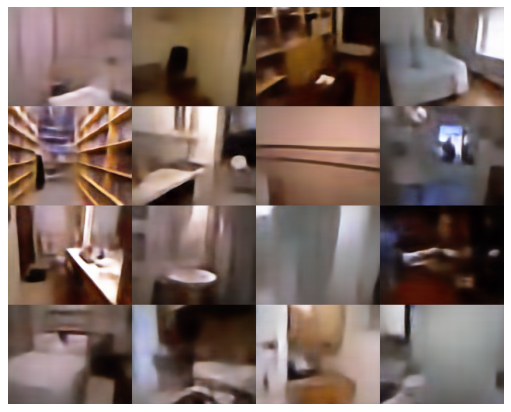

In [101]:
x, _ = iter(ds_train).get_next()
pred, mu, uncertainty = trained_model(x, training=False) # mu, var, 

figure(figsize=(8, 8), dpi=80)
plt.axis('off')
plt.imshow(gallery(pred[:16].numpy(), ncols=4));
plt.show()

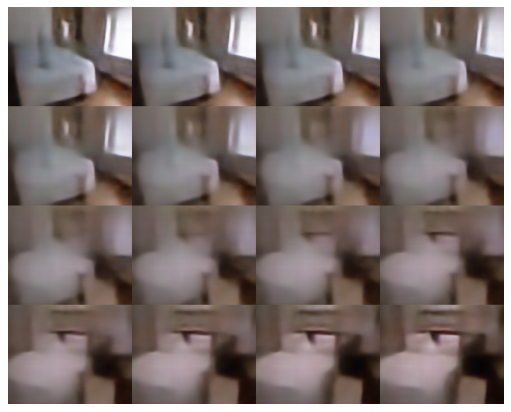

In [105]:
# Return evenly spaced numbers over a specified interval. Returns num evenly spaced samples, calculated over the interval [start, stop]
interpolated = np.linspace(start=mu[3], stop=mu[12], num=16) # (8, 480)
interpolated_out = trained_model.decoder(interpolated, training=False)

figure(figsize=(8, 8), dpi=80)
plt.axis('off')
plt.imshow(gallery(interpolated_out[:16].numpy(), ncols=4));
plt.savefig(f'/home/iaroslavelistratov/capsa/experiments/interpolation/20220911-184729kl-0.0000005-lr-x6-latent-480_5.pdf', bbox_inches='tight', format='pdf')
plt.show()

## edit images
Feed original image to get latent code and vary that latent code and decode to get edited version of the original img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


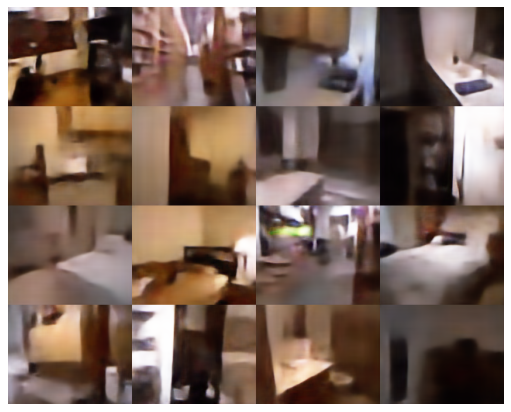

In [8]:
x, _ = iter(ds_train).get_next()
pred, mu, uncertainty = trained_model(x, training=False) # mu, var, 

figure(figsize=(8, 8), dpi=80)
plt.axis('off')
plt.imshow(gallery(pred[:16].numpy(), ncols=4));
plt.show()

##### Permute single dim

In [10]:
# select mu belonging to the image we want to edit
mu_to_edit = mu[2:3].numpy() # (1, 480)
mus_to_edit = np.repeat(mu_to_edit, 16, axis=0)
print(mus_to_edit.shape) # (16, 480)

(16, 480)


In [132]:
# print a dim we want to permute to see the scale
dim_idx = 100
mu_to_edit[0, dim_idx]
permuted_latent_dim = np.linspace(start=-mu_to_edit[0, 0], stop=mu_to_edit[0, 0], num=16) # (16, )

# replace the original dim with the permuted
mus_to_edit[:, dim_idx] = permuted_latent_dim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


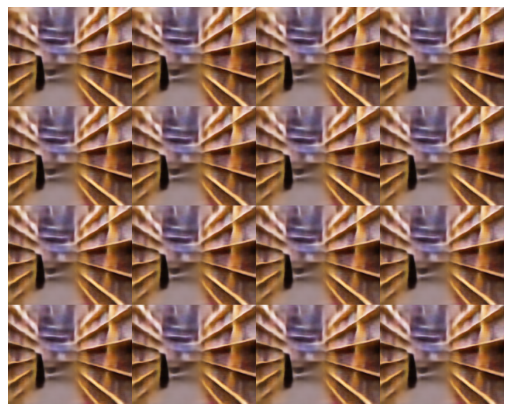

In [133]:
# run through the model
out = trained_model.decoder(mus_to_edit, training=False)

figure(figsize=(8, 8), dpi=80)
plt.axis('off')
plt.imshow(gallery(out[:16].numpy(), ncols=4));
plt.show()

##### Permute all dims

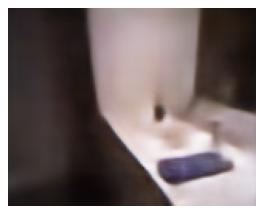

In [20]:
figure(figsize=(4, 4), dpi=80)
plt.axis('off')
plt.imshow(pred[3]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


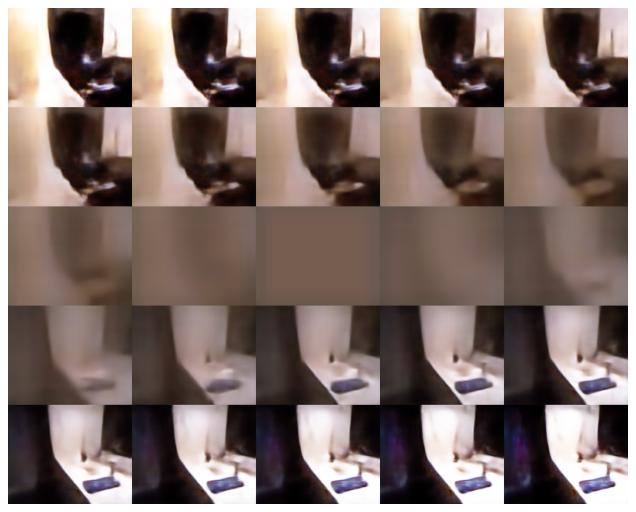

In [25]:
# select mu belonging to the image we want to edit
mu_to_edit = mu[3].numpy() # (480)
permuted_latent_dim = np.linspace(start=-2*mu_to_edit, stop=2*mu_to_edit, num=25) # (16, 480)

# run through the model
out = trained_model.decoder(permuted_latent_dim, training=False)

figure(figsize=(10, 10), dpi=80)
plt.axis('off')
plt.imshow(gallery(out.numpy(), ncols=5));
plt.savefig(f'/home/iaroslavelistratov/capsa/experiments/interpolation/20220911-184729kl-0.0000005-lr-x6-latent-480_0_1.pdf', bbox_inches='tight', format='pdf')
plt.show()